# Exercises:
* E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

* E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

* E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

* E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

* E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

* E06: meta-exercise! Think of a fun/interesting exercise and complete it.



In [2]:
import torch 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import random 
import torch.nn.functional as F
%matplotlib inline 

In [5]:
#!wget https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt
words = open('names.txt', 'r').read().splitlines() 
random.seed(42) 

In [9]:
words[999:]
chars = 'abcdefghijklmnopqrstuvwxyz' 
random.shuffle(words)
len(chars) ,len(words) 
words[:3]

['morgan', 'filippo', 'maitreya']

In [10]:
N = torch.zeros((27,27,27),dtype = torch.int32) # init 
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()} 

In [11]:
xs , ys , zs= [],[] ,[]
#print(words[:1])
for w in words:
  chs = ['.'] + list(w) + ['.']
  for u,v,w in zip(chs,chs[1:],chs[2:]): 
    #print(u,v)
    x = stoi[u]
    y = stoi[v] 
    z = stoi[w]
    xs.append(x)
    ys.append(y)  
    zs.append(z)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
zs = torch.tensor(zs)
xs,ys,zs

(tensor([ 0, 13, 15,  ...,  5, 25,  1]),
 tensor([13, 15, 18,  ..., 25,  1, 14]),
 tensor([15, 18,  7,  ...,  1, 14,  0]))

In [13]:
BLOCK = 2 #using first tow to predict the third  27*27 right? 


In [14]:
# creating dataset 

def build_dataset(words):
  X,Y=[],[]  
  context = [0]*BLOCK
  for w in words:    
    print(w)
    for ch in w + '.':   
      idx = stoi[ch]  
      print(''.join(itos[i] for i in context), '--->', itos[idx])
      X.append(context) 
      Y.append(idx) 
      context = context[1:]+[idx]
      #print(context) 
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

In [15]:
''' 
train 80%
dev 10%
test 10% 
'''  
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train,Y_train= build_dataset(words[:n1]) 
X_dev,Y_dev= build_dataset(words[n1:n2]) 
X_test,Y_test= build_dataset(words[n2:]) 

print(n1,n2)
X_train.shape,Y_train.shape

296084 333094


(torch.Size([3091801, 2]), torch.Size([3091801]))

In [38]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator = g)
W1 = torch.randn((20,300),generator = g)
B1 = torch.randn((300),generator = g) 
W2 = torch.randn((300,27),generator = g)
B2 = torch.randn((27),generator = g) 
parameters = [C,W1,B1,W2,B2]

In [39]:
for p in parameters : 
  p.requires_grad = True

In [40]:
lri = [] 
C[X_train].shape

torch.Size([3091801, 2, 10])

In [41]:
for _ in tqdm(range(200000)):
  ix = torch.randint(0,X_train.shape[0],(32,)) # batch norm 

  #forward pass 
  emb = C[X_train[ix]]
  L = emb.view(-1,20) @ W1  + B1 
  logits = torch.tanh(L@W2 + B2)
  loss = F.cross_entropy(logits,Y_train[ix])  

  #backward pass
  for p in parameters : 
    p.grad = None
  loss.backward() 

  lr = 0.1 if _ < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

loss.item()



100%|██████████| 200000/200000 [01:34<00:00, 2115.49it/s]


2.9095370769500732

In [42]:
emb = C[X_train]
L = emb.view(-1,20) @ W1  + B1 
logits = torch.tanh(L@W2 + B2)
loss = F.cross_entropy(logits,Y_train)  
loss.item()

: 

: 

In [26]:
emb = C[X_dev]
L = emb.view(-1,20) @ W1  + B1 
logits = torch.tanh(L@W2 + B2)
loss = F.cross_entropy(logits,Y_dev)  
loss.item()


2.7565925121307373

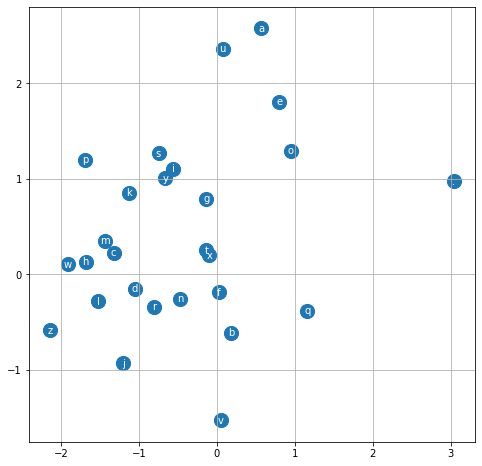

In [27]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [32]:
# sample from the model
#g = torch.Generator().manual_seed(2183637 + 10)

for _ in range(10):
    out = []
    context = [0] * BLOCK # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + B1)
      logits = h @ W2 + B2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

nodiagoiameteleneiametesele.
careiagoreiagoreiacodiacodiameteleametelenedelenedeleneilacodeleametelenedeleneiametelenedeleneiameteleneiampilacodiameteleametelenedeleneiagoiagoiagoiagoiametelemetelenedeleametelemoreiagoiagoiagoreiameteleneiagololoniametelenedelenedeleacodiagolacodiamprgatelenedeleametesenedeleiametesedeleamprgateleiloniagoreiametelenedelenedeleneiagoiamprgareiagoiagoreiameteleametesedeleneiameteleameteiagoiameteiametelemoreiagolacodiagololacodiameteseleneiagolenedeameteseleneiagolacodiameteselenedeleneiagoiametelenedelenedeleneiametelemoloniagolacodiagoiameteselenedeleneilacodiameteseleneiagoreilacodiagoiameteleametelenedelenedelenedeleneiagoreilacodiameteiagoiametesemoreiameteleneiagoiagoleameteleameteedeleameteleneiagolacodametelenedeleneiamoloniagolemoreilacodiagololaidelemolenedelenedeleameteiagoiagolololacodiametelenedelemoreiagololenedelenedeleameteseleneiagolenedelemoreiagoreiameteiametelenedelenedelenedeleneiagoiameteseleneiagololemolenedelenedeleneilacodeleamet

In [382]:
emb = C[X_test]
L = emb.view(-1,20) @ W1  + B1 
logits = torch.tanh(L@W2 + B2)
loss = F.cross_entropy(logits,Y_test)  
loss.item()

2.934157371520996